# Eigenfaces for Recognition

Summer term 2018      
Technische Universität Berlin     
Fachgebiet Maschinelles Lernen

Andre Jansen, Sourabh Raj



In [1]:
import os
import numpy as np
import matplotlib as mpl
import unittest
import pylab
import matplotlib.pyplot as plt
from PIL import Image

# Eigenfaces 
# .pgm or .png
def load_images(path: str, file_ending: str=".pgm") -> (list, int, int):

    images = []
    for file in sorted(os.listdir(path)):
        if file.endswith(file_ending):
            image = np.asarray(Image.open(path + file), dtype=np.float64)
            images.append(image)     
    
    image = images[0]
    dimension_y = image.shape[0]
    dimension_x = image.shape[1]
    
    return images, dimension_x, dimension_y

def setup_data_matrix(images: list) -> np.ndarray:
    
    D = np.zeros((len(images), images[0].shape[1] * images[0].shape[0]), dtype=np.float64)
    i = 0
    for i in range(len(images)):
        D[i] = images[i].flatten()

    return D

def pca(D: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
    
    mean_data = D.mean(0)
    
    D = D - mean_data
    u, svals, pcs = np.linalg.svd(D, full_matrices=False)
    
    return pcs, svals, mean_data

def select_eigenvectors(singular_values: np.ndarray, threshold: float = 0.8) -> int:
    """
    Compute index k so that threshold percent of magnitude of singular values is contained in
    first k singular vectors.

    singular_values: vector containing singular values
    threshold: threshold for determining k (default = 0.8)
    """    
    acc_energy = 0
    k = 0
    while acc_energy <= threshold * np.sum(singular_values):
        acc_energy = acc_energy + singular_values[k]
        k = k + 1
    return k

def project_faces(pcs: np.ndarray, images: list, mean_data: np.ndarray) -> np.ndarray:

    coefficients = np.zeros((len(images), pcs.shape[0]))

    i = 0

    for i in range(coefficients.shape[0]):
        coefficients[i] = np.dot(pcs, images[i].flatten() - mean_data)
    
    return coefficients


def identify_faces(coeffs_train: np.ndarray, pcs: np.ndarray, mean_data: np.ndarray, path_test: str, file_ending: str=".pgm") -> (
np.ndarray, list, np.ndarray):

    imgs_test, dim_x, dim_y = load_images(path_test, file_ending)
    
    coeffs_test = project_faces(pcs, imgs_test, mean_data)

    scores = np.zeros((coeffs_train.shape[0], coeffs_test.shape[0]))
    
    for i in range(coeffs_train.shape[0]):       
        for j in range(coeffs_test.shape[0]):
            scores[i][j] = np.arccos(np.dot(coeffs_train[i, :] / np.linalg.norm(coeffs_train[i, :]), coeffs_test[j, :] / np.linalg.norm(coeffs_test[j, :])))
                
    return scores, imgs_test, coeffs_test.

def plot_eigenfaces(n: int, pcs: np.ndarray, sv: np.ndarray, dim_x: int, dim_y: int):
    
    fig = pylab.figure(figsize=(15, 8))
    m = int(np.ceil(n / 2))
    n = 2 * m

    for i in range(n):
        fig.add_subplot(2, m, i + 1)
        eface = pcs[i, :].reshape((dim_y, dim_x))
        plt.imshow(eface, cmap="Greys_r")

    plt.show()


def plot_face_recognition(scores: np.ndarray, training_images: list, test_images: list, pcs: np.ndarray, coeffs_test: np.ndarray, mean_data: np.ndarray, space_threshold, class_threshold ):
    # find best match, compute confidence and plot
    
    for i in range(scores.shape[1]):
        j = np.argmin(scores[:, i]) 
        fig = pylab.figure()
        
        fig.add_subplot(1, 3, 1)
        plt.imshow(test_images[i], cmap="Greys_r") 
        
        x = (test_images[i].flatten()-mean_data)[: coeffs_test.shape[1]];
        y = coeffs_test[i];
        face_space_distance = np.arccos(np.dot(x/np.linalg.norm(x),y/np.linalg.norm(y)));
        #print (face_space_distance)
    
        face_space = face_space_distance < (1 + space_threshold);
        face_class = np.where(scores[:, i] <= class_threshold)[0].size != 0
    
        if not face_space :
            plt.xlabel('no face identified')
        elif not face_class:
            plt.xlabel('face not matched')
        else:
            fig.add_subplot(1, 3, 2)
            plt.imshow(training_images[j], cmap="Greys_r")
            plt.xlabel('Identified face')
    
            fig.add_subplot(1, 3, 1)
            plt.imshow(test_images[i], cmap="Greys_r")
            plt.xlabel('Test image')
    
            img_reconst = pcs.transpose().dot(coeffs_test[i, :]) + mean_data
            img_reconst = img_reconst.reshape(test_images[i].shape)
    
            fig.add_subplot(1, 3, 3)
            plt.imshow(img_reconst, cmap="Greys_r")
            plt.xlabel('Reconstructed face')
    
        plt.show()


Here it will be trained with 40 human subjects, 10 images each. Then it will be tested with various human face images, but also some other random images (a toast, an airplane for example).

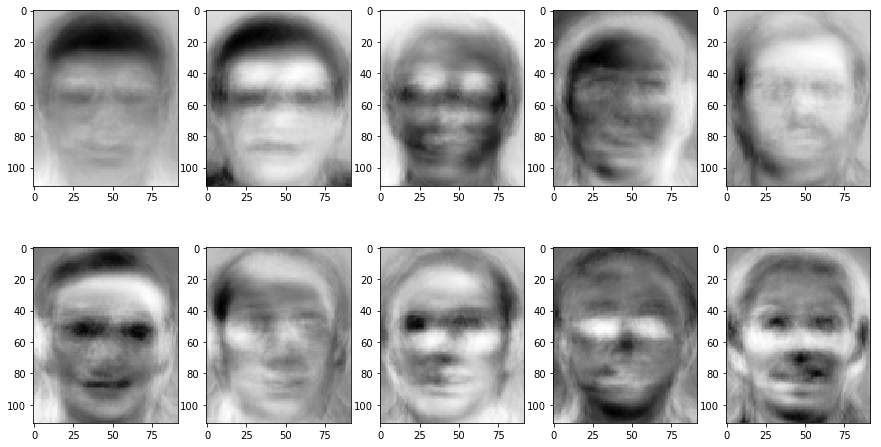

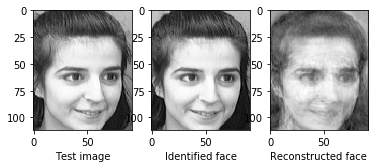

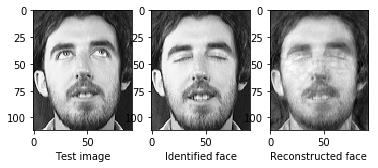

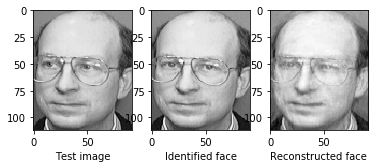

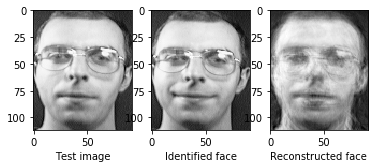

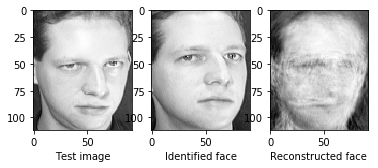

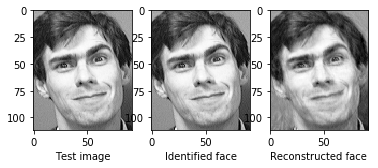

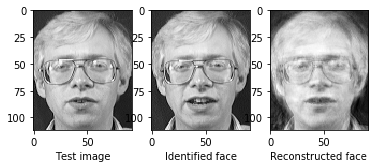

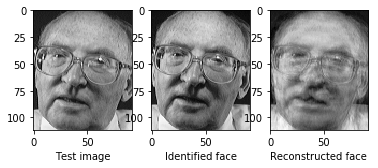

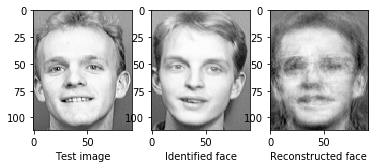

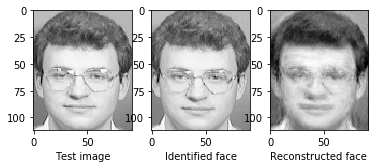

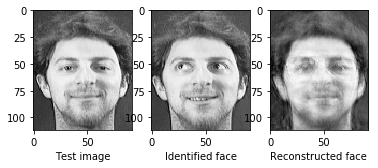

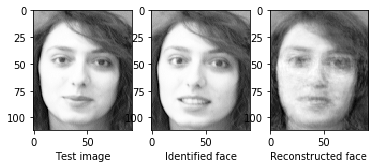

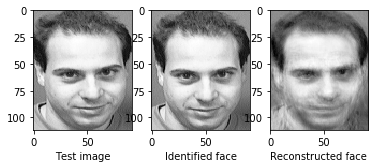

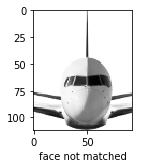

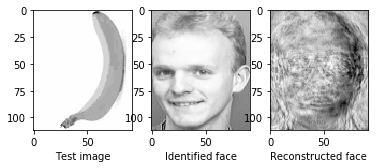

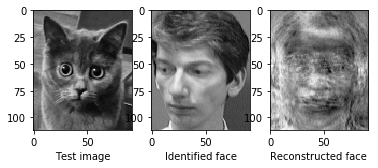

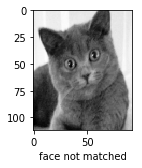

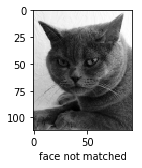

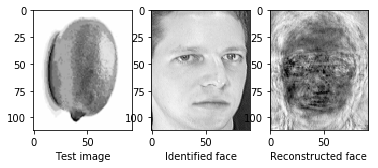

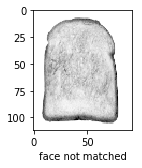

In [9]:
space_threshold = 0.8
class_threshold = 0.8

imgs_train, dim_x, dim_y = load_images("./data/human/train/")

D = setup_data_matrix(imgs_train)

# Perform principal component analysis
pcs, singular_values, mean_data = pca(D)
     
# compute threshold for 90% of spectral energy
k = select_eigenvectors(singular_values, class_threshold)

# cut off number of pcs if desired
pcs = pcs[0:k, :]
# compute coefficients of input in eigenbasis
coeffs_train = project_faces(pcs, imgs_train, mean_data)

# perform classical face recognition
scores, imgs_test, coeffs_test = identify_faces(coeffs_train, pcs, mean_data, './data/human/test/')

# Visualize the eigenfaces/principal components
plot_eigenfaces(10, pcs, singular_values, dim_x, dim_y)

plot_face_recognition(scores, imgs_train, imgs_test, pcs, coeffs_test, mean_data, space_threshold, class_threshold)


Now the algorithm will train with cat images. Then it will be tested for the same cat, and human faces.

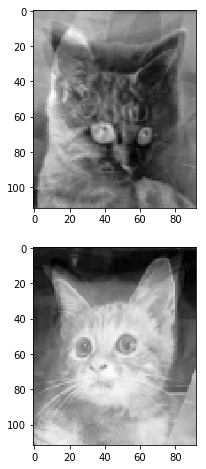

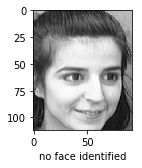

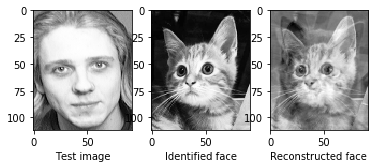

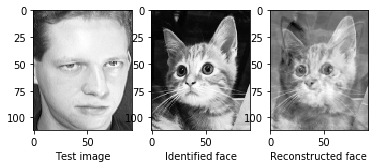

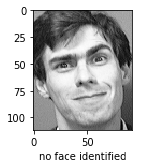

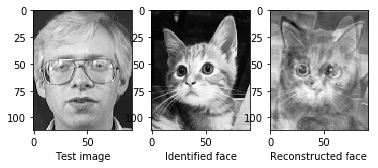

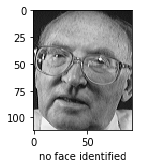

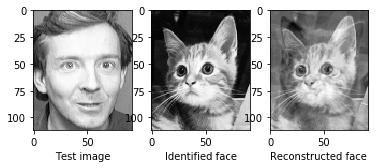

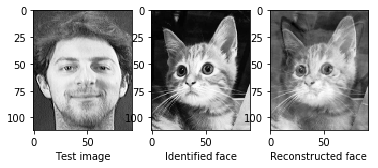

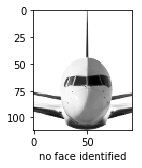

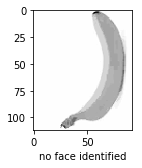

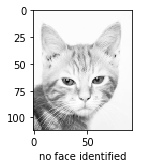

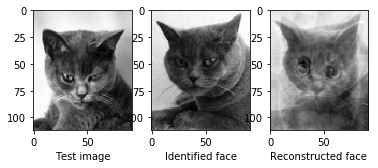

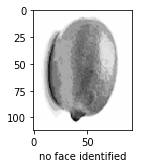

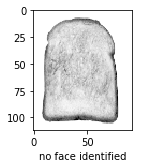

In [10]:
space_threshold = 0.8
class_threshold = 0.8

imgs_train, dim_x, dim_y = load_images("./data/cat/train/")

D = setup_data_matrix(imgs_train)

# Perform principal component analysis
pcs, singular_values, mean_data = pca(D)
     
# compute threshold for 90% of spectral energy
k = select_eigenvectors(singular_values, class_threshold)

# cut off number of pcs if desired
pcs = pcs[0:k, :]
# compute coefficients of input in eigenbasis
coeffs_train = project_faces(pcs, imgs_train, mean_data)

# perform classical face recognition
scores, imgs_test, coeffs_test = identify_faces(coeffs_train, pcs, mean_data, './data/cat/test/')

# Visualize the eigenfaces/principal components
plot_eigenfaces(2, pcs, singular_values, dim_x, dim_y)

plot_face_recognition(scores, imgs_train, imgs_test, pcs, coeffs_test, mean_data, space_threshold, class_threshold)


This code will run the images of format "PNG" as this contains some other set of data.

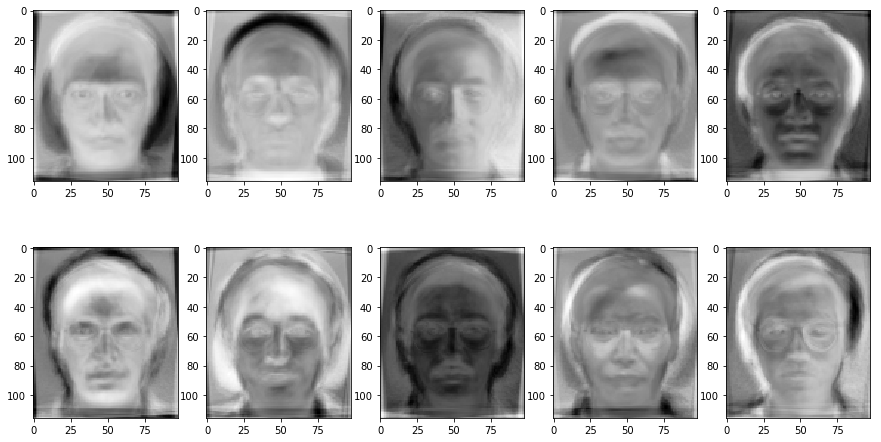

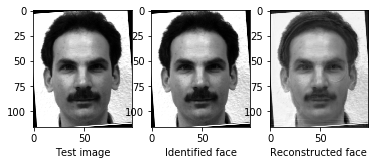

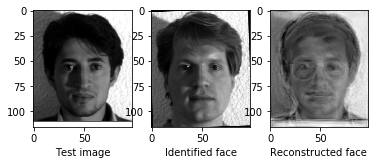

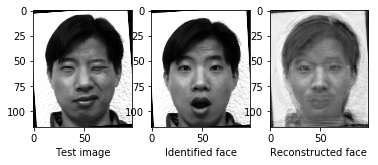

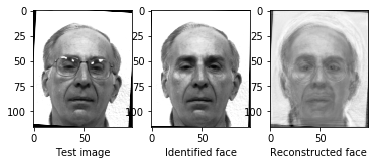

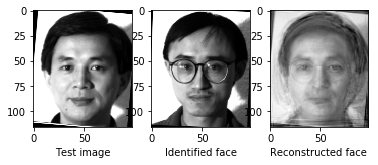

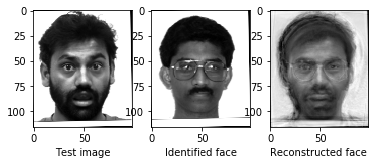

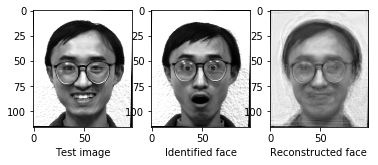

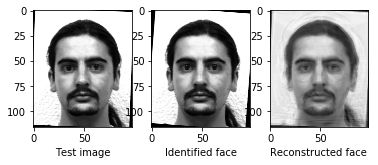

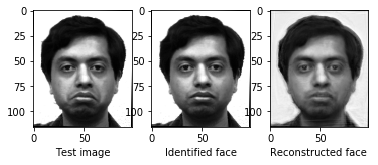

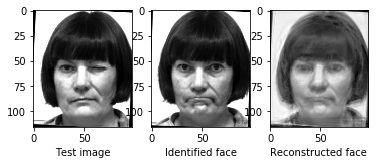

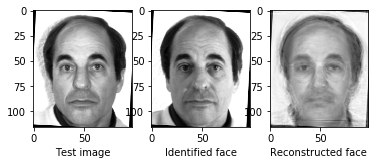

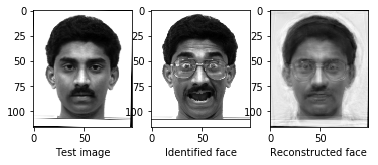

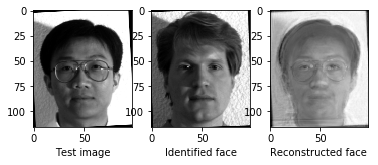

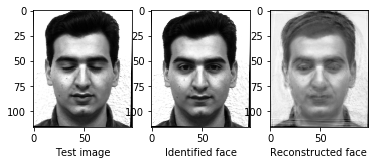

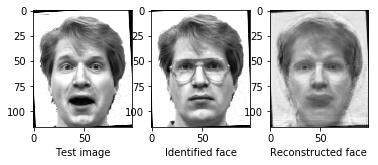

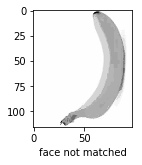

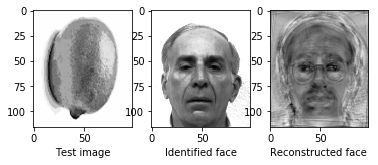

In [13]:
space_threshold = 1.0
class_threshold = 0.9

imgs_train, dim_x, dim_y = load_images("./data/human_png/train/", ".png")

D = setup_data_matrix(imgs_train)

# Perform principal component analysis
pcs, singular_values, mean_data = pca(D)
     
# compute threshold for 90% of spectral energy
k = select_eigenvectors(singular_values, class_threshold)

# cut off number of pcs if desired
pcs = pcs[0:k, :]
# compute coefficients of input in eigenbasis
coeffs_train = project_faces(pcs, imgs_train, mean_data)

# perform classical face recognition
scores, imgs_test, coeffs_test = identify_faces(coeffs_train, pcs, mean_data, './data/human_png/test/', ".png")

# Visualize the eigenfaces/principal components
plot_eigenfaces(10, pcs, singular_values, dim_x, dim_y)

plot_face_recognition(scores, imgs_train, imgs_test, pcs, coeffs_test, mean_data, space_threshold, class_threshold)